In [82]:
import pandas as pd
import numpy as np
import os

import logging
logging.getLogger().setLevel(logging.INFO)

from alphabase.spectral_library.flat import SpecLibFlat
from alphabase.spectral_library.base import SpecLibBase
from alphabase.spectral_library.reader import LibraryReaderBase
from alphadia.extraction.utils import reannotate_fragments
from alphabase.psm_reader import psm_reader_provider

In [83]:
def fragment_number(precursor_df, fragment_intensity_df) :
    if not set(['frag_start_idx', 'frag_stop_idx']).issubset(precursor_df.columns):
        warnings.warn('frag_start_idx and frag_stop_idx not in dataframe')
        return
    
    n_fragments = []
    
    for start, stop in zip(precursor_df['frag_start_idx'].values, precursor_df['frag_stop_idx'].values):
        n_fragments += [np.sum(fragment_intensity_df.iloc[start:stop].values > 0)]

    precursor_df['n_fragments'] = n_fragments

In [84]:
large_lib = SpecLibBase()
large_lib_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/21min_Evosep_HeLa_BR14_48fractions_diaPASEF_py_diAID_2.hdf'
large_lib.load_hdf(large_lib_location, load_mod_seq=True)


large_lib.precursor_df = large_lib.precursor_df[large_lib.precursor_df['rt_norm'] > -0.5]

# scale rt_norm to from min max to 0-1
large_lib.precursor_df['rt_norm'] = (large_lib.precursor_df['rt_norm'] - large_lib.precursor_df['rt_norm'].min())/(large_lib.precursor_df['rt_norm'].max() - large_lib.precursor_df['rt_norm'].min())

In [92]:
small_lib = SpecLibBase()
small_lib_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/library_MSFragger.hdf'
small_lib.load_hdf(small_lib_location, load_mod_seq=True)

small_lib.precursor_df['rt_norm'] = (small_lib.precursor_df['rt_norm'] - small_lib.precursor_df['rt_norm'].min())/(small_lib.precursor_df['rt_norm'].max() - small_lib.precursor_df['rt_norm'].min())

In [93]:
small_lib.hash_precursor_df()
small_lib_df = small_lib._precursor_df
large_lib.hash_precursor_df()
large_lib_df = large_lib._precursor_df

In [94]:
shared_precursors_hashes = set(small_lib_df.mod_seq_charge_hash).intersection(set(large_lib_df.mod_seq_charge_hash))

In [95]:
len(shared_precursors_hashes)

90136

In [74]:
name = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/library_48_fractions_reduced.hdf'
reduced_lib = SpecLibBase()
reduced_lib._precursor_df = large_lib_df[large_lib_df.mod_seq_charge_hash.isin(shared_precursors_hashes)].copy()
reduced_lib._fragment_mz_df = large_lib._fragment_mz_df
reduced_lib._fragment_intensity_df = large_lib.fragment_intensity_df

reduced_lib.remove_unused_fragments()
reduced_lib.save_hdf(name)

In [96]:
name = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/library_48_fractions_reduced_rt.hdf'
reduced_lib_rt = SpecLibBase()
reduced_lib_rt._precursor_df = large_lib_df[large_lib_df.mod_seq_charge_hash.isin(shared_precursors_hashes)].copy()
reduced_lib_rt._fragment_mz_df = large_lib._fragment_mz_df
reduced_lib_rt._fragment_intensity_df = large_lib.fragment_intensity_df

reduced_lib_rt._precursor_df.drop(columns=['rt_norm'], inplace=True)
reduced_lib_rt._precursor_df = reduced_lib_rt._precursor_df.merge(small_lib_df[['mod_seq_charge_hash', 'rt_norm']], on='mod_seq_charge_hash', suffixes=('', ''))

reduced_lib_rt.remove_unused_fragments()
reduced_lib_rt.save_hdf(name)

(array([6.000e+00, 4.000e+00, 3.500e+01, 4.900e+01, 1.050e+02, 1.500e+02,
        2.280e+02, 2.760e+02, 3.600e+02, 4.210e+02, 5.100e+02, 6.640e+02,
        6.810e+02, 6.400e+02, 7.290e+02, 7.940e+02, 7.880e+02, 9.360e+02,
        8.720e+02, 1.119e+03, 9.120e+02, 1.191e+03, 1.100e+03, 1.034e+03,
        1.390e+03, 1.173e+03, 1.421e+03, 1.304e+03, 1.421e+03, 1.487e+03,
        1.704e+03, 1.585e+03, 1.680e+03, 1.502e+03, 1.775e+03, 1.672e+03,
        1.775e+03, 1.641e+03, 1.717e+03, 1.978e+03, 1.599e+03, 1.907e+03,
        1.730e+03, 1.811e+03, 1.967e+03, 2.067e+03, 1.946e+03, 1.951e+03,
        1.986e+03, 1.803e+03, 2.030e+03, 1.866e+03, 1.723e+03, 1.719e+03,
        2.041e+03, 1.880e+03, 1.571e+03, 1.850e+03, 1.827e+03, 1.373e+03,
        1.513e+03, 1.696e+03, 1.440e+03, 1.486e+03, 1.286e+03, 1.144e+03,
        1.118e+03, 7.190e+02, 7.570e+02, 8.300e+02, 5.520e+02, 3.400e+02,
        1.620e+02, 1.320e+02, 1.340e+02, 1.440e+02, 1.140e+02, 1.240e+02,
        1.280e+02, 1.400e+02, 1.360e+0

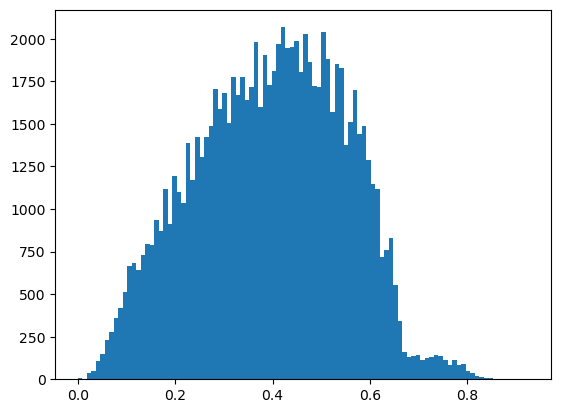

In [97]:
plt.hist(reduced_lib_rt.precursor_df['rt_norm'].values, bins=100)

In [76]:
name = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/library_48_fractions_reduced_mobility.hdf'
reduced_lib_mobility = SpecLibBase()
reduced_lib_mobility._precursor_df = large_lib_df[large_lib_df.mod_seq_charge_hash.isin(shared_precursors_hashes)].copy()
reduced_lib_mobility._fragment_mz_df = large_lib._fragment_mz_df
reduced_lib_mobility._fragment_intensity_df = large_lib.fragment_intensity_df

reduced_lib_mobility._precursor_df.drop(columns=['mobility'], inplace=True)
reduced_lib_mobility._precursor_df = reduced_lib_mobility._precursor_df.merge(small_lib_df[['mod_seq_charge_hash', 'mobility']], on='mod_seq_charge_hash', suffixes=('',''))

reduced_lib_mobility.remove_unused_fragments()
reduced_lib_mobility.save_hdf(name)

In [77]:
name = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/library_48_fractions_reduced_rt_mobility.hdf'
reduced_lib_both = SpecLibBase()
reduced_lib_both._precursor_df = large_lib_df[large_lib_df.mod_seq_charge_hash.isin(shared_precursors_hashes)].copy()
reduced_lib_both._fragment_mz_df = large_lib._fragment_mz_df
reduced_lib_both._fragment_intensity_df = large_lib.fragment_intensity_df

reduced_lib_both._precursor_df.drop(columns=['mobility','rt_norm'], inplace=True)
reduced_lib_both._precursor_df = reduced_lib_both._precursor_df.merge(small_lib_df[['mod_seq_charge_hash', 'mobility','rt_norm']], on='mod_seq_charge_hash', suffixes=('',''))

reduced_lib_both.remove_unused_fragments()
reduced_lib_both.save_hdf(name)



In [78]:
name = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/library_48_fractions_reduced_fragments.hdf'

reduced_lib_fragments = SpecLibBase()
reduced_lib_fragments._precursor_df = large_lib_df[large_lib_df.mod_seq_charge_hash.isin(shared_precursors_hashes)].copy()
reduced_lib_fragments._fragment_mz_df = small_lib._fragment_mz_df
reduced_lib_fragments._fragment_intensity_df = small_lib.fragment_intensity_df

reduced_lib_fragments._precursor_df.drop(columns=['frag_start_idx','frag_stop_idx'], inplace=True)
reduced_lib_fragments._precursor_df = reduced_lib_fragments._precursor_df.merge(small_lib_df[['mod_seq_charge_hash', 'frag_start_idx','frag_stop_idx']], on='mod_seq_charge_hash', suffixes=('',''))

reduced_lib_fragments.remove_unused_fragments()
reduced_lib_fragments.save_hdf(name)

In [79]:
name = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/library_48_fractions_reduced_rt_mobility_fragments.hdf'
reduced_lib_both = SpecLibBase()
reduced_lib_both._precursor_df = large_lib_df[large_lib_df.mod_seq_charge_hash.isin(shared_precursors_hashes)].copy()
reduced_lib_both._fragment_mz_df = small_lib._fragment_mz_df
reduced_lib_both._fragment_intensity_df = small_lib.fragment_intensity_df

reduced_lib_both._precursor_df.drop(columns=['mobility','rt_norm', 'frag_start_idx', 'frag_stop_idx'], inplace=True)
reduced_lib_both._precursor_df = reduced_lib_both._precursor_df.merge(small_lib_df[['mod_seq_charge_hash', 'mobility','rt_norm', 'frag_start_idx', 'frag_stop_idx']], on='mod_seq_charge_hash', suffixes=('',''))

reduced_lib_both.remove_unused_fragments()
reduced_lib_both.save_hdf(name)

In [80]:
fragment_number(reduced_lib_both.precursor_df, reduced_lib_both.fragment_intensity_df)
fragment_number(reduced_lib_fragments.precursor_df, reduced_lib_fragments.fragment_intensity_df)

In [101]:
name = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/library_48_fractions_predicted.hdf'

from peptdeep.pretrained_models import ModelManager
from alphabase.peptide.fragment import get_charged_frag_types

frag_types = get_charged_frag_types(
    ['b','y'], 
    2
)

model_mgr = ModelManager()

model_mgr.nce = 30
model_mgr.instrument = 'timsTOF'

reduced_lib_predicted = SpecLibBase()
reduced_lib_predicted._precursor_df = large_lib_df

res = model_mgr.predict_all(
    reduced_lib_predicted.precursor_df,
    predict_items=['ms2'],
    frag_types = frag_types,
)

reduced_lib_predicted._precursor_df = res['precursor_df']
reduced_lib_predicted._fragment_mz_df = res['fragment_mz_df']
reduced_lib_predicted._fragment_intensity_df = res['fragment_intensity_df']

reduced_lib_predicted.save_hdf(name)

2023-03-03 22:23:19> Using multiprocessing with 8 processes ...
2023-03-03 22:23:19> Predicting ms2 ...


100%|██████████| 46/46 [01:40<00:00,  2.18s/it]


In [103]:
name = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/library_MSFragger_predicted.hdf'

from peptdeep.pretrained_models import ModelManager
from alphabase.peptide.fragment import get_charged_frag_types

frag_types = get_charged_frag_types(
    ['b','y'], 
    2
)

model_mgr = ModelManager()

model_mgr.nce = 30
model_mgr.instrument = 'timsTOF'

reduced_lib_predicted = SpecLibBase()
reduced_lib_predicted._precursor_df = small_lib_df

res = model_mgr.predict_all(
    reduced_lib_predicted.precursor_df,
    predict_items=['ms2'],
    frag_types = frag_types,
)

reduced_lib_predicted._precursor_df = res['precursor_df']
reduced_lib_predicted._fragment_mz_df = res['fragment_mz_df']
reduced_lib_predicted._fragment_intensity_df = res['fragment_intensity_df']

reduced_lib_predicted.save_hdf(name)

2023-03-03 22:27:11> Using multiprocessing with 8 processes ...
2023-03-03 22:27:11> Predicting ms2 ...


100%|██████████| 42/42 [00:24<00:00,  1.70it/s]


In [106]:
reduced_lib_predicted._precursor_df['elution_group_idx'] = np.arange(len(reduced_lib_predicted._precursor_df))

In [107]:
reduced_lib_predicted.save_hdf(name)